In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split
import seaborn as sns

In [16]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [17]:
data

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,25.735683,25.735683,25.607645,25.717392,1003200
1993-02-01,25.735673,25.900293,25.735673,25.900293,480500
1993-02-02,25.881999,25.973455,25.827126,25.955164,201300
1993-02-03,25.991755,26.247831,25.973463,26.229540,529400
1993-02-04,26.321001,26.394166,26.028343,26.339293,531500
...,...,...,...,...,...
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400
2020-12-29,370.188721,370.376883,367.237579,367.861481,53680500


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data['price'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
price = data[['price']]
price

,price
Date,
1993-01-29,-0.998197
1993-02-01,-0.997136
1993-02-02,-0.996818
1993-02-03,-0.995226
1993-02-04,-0.994590
...,...
2020-12-24,0.971972
2020-12-28,0.990179
2020-12-29,0.986101


In [10]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [19]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (5610, 19, 1)
y_train.shape =  (5610, 1)
x_test.shape =  (1403, 19, 1)
y_test.shape =  (1403, 1)


In [20]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [23]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [25]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.276510626077652
Epoch  1 MSE:  0.15822415053844452
Epoch  2 MSE:  0.06328271329402924
Epoch  3 MSE:  0.059423163533210754
Epoch  4 MSE:  0.05058479681611061
Epoch  5 MSE:  0.03496873378753662
Epoch  6 MSE:  0.03927517682313919
Epoch  7 MSE:  0.04472408816218376
Epoch  8 MSE:  0.04547273740172386
Epoch  9 MSE:  0.04199680685997009
Epoch  10 MSE:  0.0367325060069561
Epoch  11 MSE:  0.03269064426422119
Epoch  12 MSE:  0.03220617398619652
Epoch  13 MSE:  0.03445834293961525
Epoch  14 MSE:  0.034696314483881
Epoch  15 MSE:  0.030634276568889618
Epoch  16 MSE:  0.025864863768219948
Epoch  17 MSE:  0.023649372160434723
Epoch  18 MSE:  0.022974198684096336
Epoch  19 MSE:  0.020406115800142288
Epoch  20 MSE:  0.01377111952751875
Epoch  21 MSE:  0.00855698250234127
Epoch  22 MSE:  0.013175706379115582
Epoch  23 MSE:  0.0030536726117134094
Epoch  24 MSE:  0.010583373717963696
Epoch  25 MSE:  0.00745974387973547
Epoch  26 MSE:  0.003453194862231612
Epoch  27 MSE:  0.00748373614624

In [27]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

[Text(-1000.0, 0, ''),
 Text(0.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(5000.0, 0, ''),
 Text(6000.0, 0, '')]

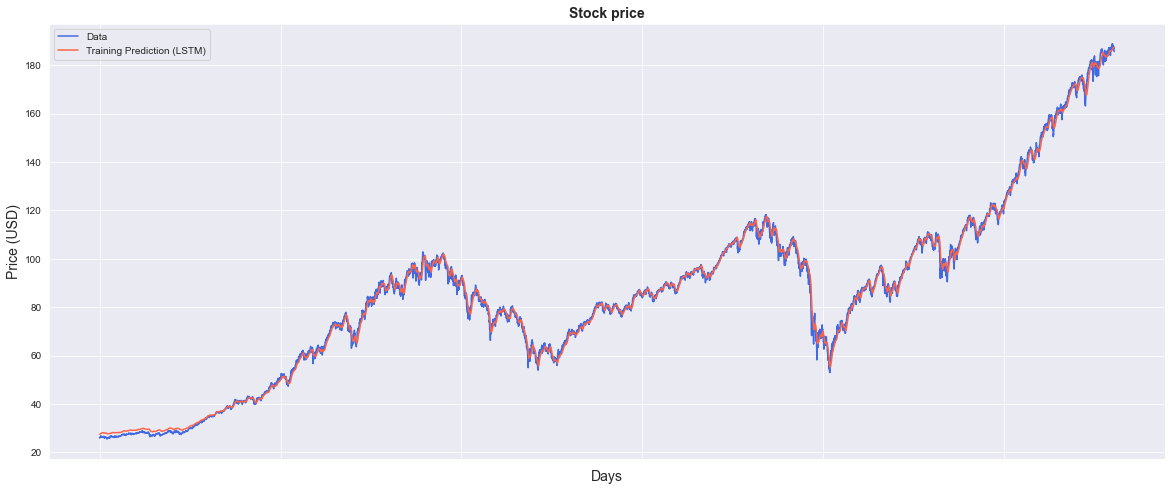

In [40]:
fig = plt.figure(figsize=(20,8))

ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (USD)", size = 14)
ax.set_xticklabels('', size=10)

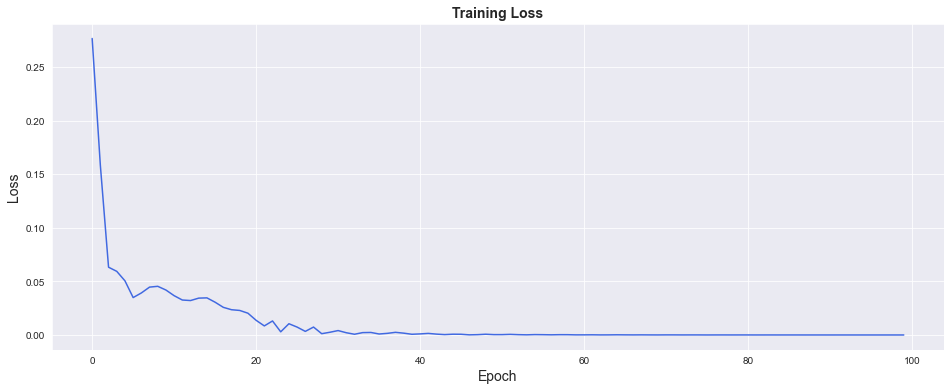

In [41]:
fig = plt.figure(figsize=(20,8))
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [42]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 1.79 RMSE
Test Score: 52.73 RMSE


In [49]:
y_test = pd.DataFrame(y_test)
y_test

,0
0,184.482986
1,184.456482
2,186.668686
3,187.270447
4,185.836929
...,...
1398,364.009186
1399,365.425323
1400,368.564606
1401,367.861481


In [50]:
y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred

,0
0,187.595261
1,187.439575
2,187.258148
3,187.152161
4,187.081665
...,...
1398,222.809158
1399,222.810837
1400,222.813354
1401,222.819244


[Text(-200.0, 0, ''),
 Text(0.0, 0, ''),
 Text(200.0, 0, ''),
 Text(400.0, 0, ''),
 Text(600.0, 0, ''),
 Text(800.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1200.0, 0, ''),
 Text(1400.0, 0, ''),
 Text(1600.0, 0, '')]

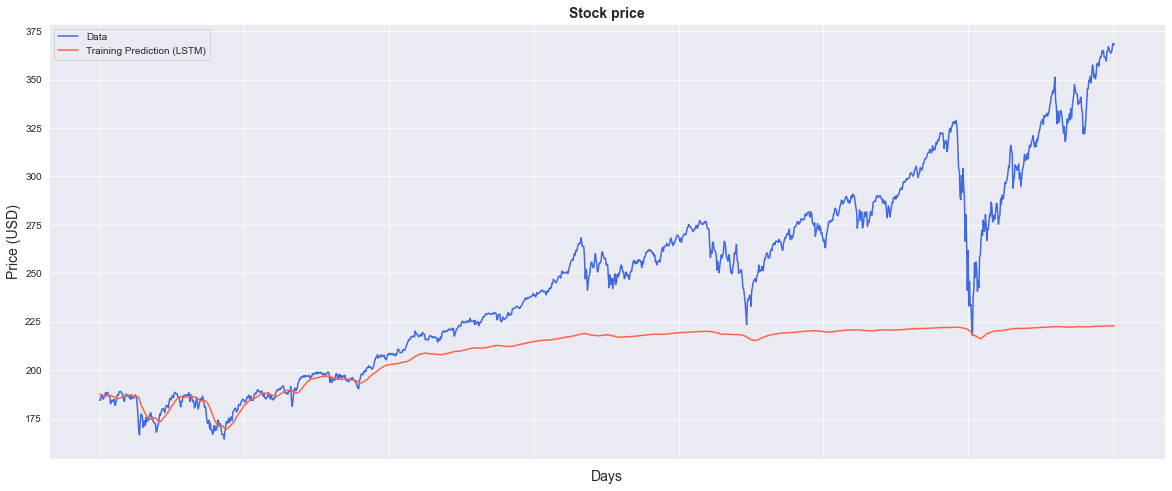

In [51]:
fig = plt.figure(figsize=(20,8))

ax = sns.lineplot(x = y_test.index, y = y_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = y_test_pred.index, y = y_test_pred[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (USD)", size = 14)
ax.set_xticklabels('', size=10)